In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

from datetime import datetime
import math
import cv2
from PIL import Image

import vgg16_v1

C:\Users\HSJung\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 4
image_num = 724 #The number of image data
eval_num = 196
batch_num_t = math.ceil(image_num/batch_size)
batch_num_e = math.ceil(eval_num/batch_size)

epoch_num = 100
classes_num = 21
MOVING_AVERAGE_DECAY = 0.9999
image_WH = 256

loss_ = np.zeros(100)

ckpt_loc = 'checkpoint'
eval_loc = r'\\cat\share\정한슬\cat_data\data\eval'
data_loc = r'\\cat\share\정한슬\cat_data\data\train'
text = r'\\cat\share\정한슬\cat_data\data'

In [3]:
if not os.path.isdir(ckpt_loc):
    os.mkdir(ckpt_loc)

In [4]:
#make training data vector
with open(os.path.join(text,'training.txt'),'r') as f:
    #suffle images for training
    lines = random.sample(f.readlines(),image_num)
image = np.ndarray([image_num,image_WH,image_WH,3])
label = np.ndarray([image_num])

i = 0
for line in lines:
    if i == image_num: break
    #print(cv2.imread(line[:-4], CV_LOAD_IMAGE_COLOR))
    label[i] = np.asanyarray(int(line[-3:-1])).reshape([1])
    image[i] = np.asanyarray(Image.open(line[:-4])).reshape((image_WH,image_WH,3))
    i += 1
print("train image :"+str(i))

train image :724


In [5]:
#make validation data vector
with open(os.path.join(text,'evaluating.txt'),'r') as f:
    lines = random.sample(f.readlines(),eval_num)
    
eval_image = np.ndarray([eval_num,image_WH,image_WH,3])
eval_label = np.ndarray([eval_num])

i = 0
for line in lines:
    if i == image_num: break
    eval_label[i] = np.asanyarray(int(line[-3:-1])).reshape([1])
    eval_image[i] = np.asanyarray(Image.open(line[:-4])).reshape((image_WH,image_WH,3))
    i += 1
print("eval image : "+str(i))

eval image : 196


In [ ]:
with tf.Graph().as_default() as g:
    with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.6)))) as sess:
        '''
        #Load meta graph
        saver = tf.train.import_meta_graph(os.path.join(ckpt_loc,'TL-model-1280.meta'))
        
        #Load weights
        saver.restore(sess, tf.train.latest_checkpoint(ckpt_loc))
        #make graph
        graph = tf.get_default_graph()
        
        # If you don't know name of variables, remove '''''' 
        """
        
        for op in graph.get_operations():
            print(op.name)
        """
        
        #Fix input and ouput
        inputs = graph.get_tensor_by_name("images:0")
        labels = graph.get_tensor_by_name("labels:0")
        prob = graph.get_tensor_by_name("content_vgg/fc8/probability:0")
        
        #For saving checkpoint
        ckpt = tf.train.get_checkpoint_state(ckpt_loc)
        '''
        
        #variables for input and ground truth
        print('program is started')
        images = tf.placeholder("float32", [None, image_WH, image_WH, 3],name = 'images')
        labels = tf.placeholder("int64",[None], name = 'labels')

        vgg = vgg16_v1.Vgg16()
 
        with tf.name_scope("content_vgg"):
            vgg.build(images,labels)
            sess.run(tf.global_variables_initializer())
            
            filter_img = tf.summary.FileWriter('filter',sess.graph)
            saver = tf.train.Saver()
            
            start = datetime.now()
            print(datetime.now(),' Running starts!')
            
            
            for epoch in range(epoch_num):
                img_count = 0
                loss_sum = 0.0
                acc_sum_t = 0.0 
                acc_sum_e = 0.0
                eval_count = 0
                
                for batch in range(batch_num_t):
                    feed_dict_train = {images: image[batch*batch_size:(batch+1)*batch_size], labels: label[batch*batch_size:(batch+1)*batch_size]}
                    
                    loss, train_acc, _ = sess.run([vgg.cost, vgg.accuracy, vgg.train], feed_dict=feed_dict_train)
                    
                    img_count += batch_size
                    
                    
                    loss_sum +=  loss
                    acc_sum_t += train_acc
                
                for batch in range(batch_num_e):
                    feed_dict_eval = {images: eval_image[batch*batch_size:(batch+1)*batch_size], labels: eval_label[batch*batch_size:(batch+1)*batch_size]}
                    eval_acc= sess.run(vgg.accuracy, feed_dict=feed_dict_eval)

                    acc_sum_e += eval_acc
                
                loss_[epoch] = np.sum(loss_sum)/batch_num_t
                acc_t = np.sum(acc_sum_t)/batch_num_t
                acc_e = np.sum(acc_sum_e)/batch_num_e
                global_step = image_num*(epoch+1)
                
                print('[',datetime.now(),"%2d" %(epoch+1),"epoch] loss : %7.4f" % loss_[epoch], "train accuracy : %.6f" % acc_t, "validation accuracy : %.6f" % acc_e)
                
                if epoch % 10 == 0:
                    saver.save(sess,os.path.join(ckpt_loc,"TL-model"),global_step = global_step) #write_meta_graph=False meta 원하지 않음
                    if acc_t == 1.0:
                        break
            print(datetime.now(),' Running finished!')
            print('-img.close')
            filter_img.close()

program is started
C:\Users\HSJung\jupyterNotebook\01_Wom_Classification\vgg16\vgg16.npy
npy file loaded
build model started
build model finished: 12s
2018-09-27 17:10:11.264331  Running starts!
[ 2018-09-27 17:12:00.796970  1 epoch] loss : 19246.0511 train accuracy : 0.444751 validation accuracy : 0.535714
[ 2018-09-27 17:13:53.123553  2 epoch] loss : 3354.0262 train accuracy : 0.780387 validation accuracy : 0.576531
[ 2018-09-27 17:15:32.769561  3 epoch] loss : 2398.1233 train accuracy : 0.837017 validation accuracy : 0.637755
[ 2018-09-27 17:17:12.261688  4 epoch] loss : 2054.2125 train accuracy : 0.886740 validation accuracy : 0.647959
[ 2018-09-27 17:18:51.892890  5 epoch] loss : 1207.4231 train accuracy : 0.907459 validation accuracy : 0.668367
[ 2018-09-27 17:20:32.398794  6 epoch] loss : 1182.8112 train accuracy : 0.915746 validation accuracy : 0.673469
[ 2018-09-27 17:22:12.355544  7 epoch] loss : 576.4886 train accuracy : 0.953039 validation accuracy : 0.673469
[ 2018-09-27 1

0.0
0.0


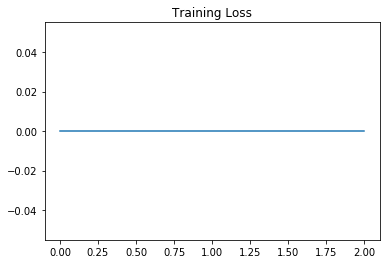

In [21]:
print(loss_[0])
print(loss_[1])
x = loss_[0:3]
plt.plot(x)
plt.title("Training Loss")
plt.show()